In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor as RF
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import warnings
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import math
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

warnings.filterwarnings('ignore')

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
data=pd.read_csv('train.csv')
test_main_data=pd.read_csv('test.csv')

In [3]:
MAIN_DATA_RANDOM_STATE = 8
train, valid = train_test_split(data, test_size=0.3, random_state = MAIN_DATA_RANDOM_STATE)

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7000 entries, 6983 to 4547
Data columns (total 20 columns):
Id               7000 non-null int64
DistrictId       7000 non-null int64
Rooms            7000 non-null float64
Square           7000 non-null float64
LifeSquare       5472 non-null float64
KitchenSquare    7000 non-null float64
Floor            7000 non-null int64
HouseFloor       7000 non-null float64
HouseYear        7000 non-null int64
Ecology_1        7000 non-null float64
Ecology_2        7000 non-null object
Ecology_3        7000 non-null object
Social_1         7000 non-null int64
Social_2         7000 non-null int64
Social_3         7000 non-null int64
Healthcare_1     3628 non-null float64
Helthcare_2      7000 non-null int64
Shops_1          7000 non-null int64
Shops_2          7000 non-null object
Price            7000 non-null float64
dtypes: float64(8), int64(9), object(3)
memory usage: 1.1+ MB


# Предсказываем как есть для теста

In [5]:
egg_pred = None

def random_forest_cluster_predict(xtrain, xvalid, target_price, needcomment, r_state):
    
    xtrain = xtrain.copy()
    xvalid = xvalid.copy()
    
    xtrain = xtrain.drop('cluster', axis=1)
    xvalid = xvalid.drop('cluster', axis=1)
   
    
    params={'min_samples_leaf':[2,4,7,10],
                'n_estimators':[10,25,50,75,100,125],
                'max_depth':[3,5,7,10]
               }

    regr=GridSearchCV(RF(random_state=r_state),param_grid=params,cv=2,n_jobs=-1)
    regr.fit(xtrain, target_price)

    if needcomment:
        print(regr.best_params_)
        print(" "*5, 'Лучшая оценка регрессии:', regr.best_score_)

    RFR=RF(max_depth= regr.best_params_['max_depth'], 
                   min_samples_leaf= regr.best_params_['min_samples_leaf'], 
                   n_estimators= regr.best_params_['n_estimators'],
                   random_state=r_state,
                   n_jobs=-1)

    RFR.fit(xtrain,target_price)

    if needcomment:
        ffi = RFR.feature_importances_
        egg = {'columns':xtrain.columns, 'ffi':ffi}

        spam = pd.DataFrame(egg)
        spam.sort_values(by='ffi', axis=0, ascending=False, inplace=True)

        print(" "*5, "Важность признаков: ", spam)

    price_pred = RFR.predict(xvalid)
    
    return price_pred
    

def random_forest_predict_current(df, vdf, columns, byPriceMeter, cluster_counts = 0, 
                                    needcomment = True, r_state=44, finaly = False):

    if needcomment:
        print('АНАЛИЗ / ПРОГНОЗ ЦЕНЫ ЗА МЕТР:', byPriceMeter, columns)
   
    xtrain = df.copy()
    xvalid = vdf.copy()
    
    def prepare_data(df):
        
        if 'Price' in df.columns:
            df = df.drop('Price', axis=1)
        if 'PriceM2' in df.columns:
            df = df.drop('PriceM2', axis=1)
        
        df = df.drop('Id', axis=1)
        
        columns_loc = df.columns
        columnscheck = list(columns) + ['cluster']
        for k in columns_loc:
            if not k in columnscheck:
                df.drop(k, axis=1, inplace=True)

        df = pd.get_dummies(df)
        
        return df
        
    #Технический долг. Так себе решение, но весь блокнот переделывать лень.
    if 'Square_' in xvalid.columns: 
        check_square = xvalid['Square_']
    else:
        check_square = xvalid['Square']
        
    if byPriceMeter:
        target_price = xtrain['PriceM2']
        if not finaly:
            check_price = xvalid['PriceM2']
    else:
        target_price = xtrain['Price']
        if not finaly:
            check_price = xvalid['Price']

    xtrain = prepare_data(xtrain)
    xvalid = prepare_data(xvalid)
    
    if not 'cluster' in xtrain.columns:
        xtrain['cluster'] = 0
        xvalid['cluster'] = 0
        
    price_pred = None
    check_price_ = None
    check_square_ = None
    
    for i in range(max(cluster_counts, 1)):
        
        if needcomment:
            print("="*5, 'сектор', i, "="*5)
        
        local_price = target_price[xtrain.cluster == i]
        spam = xtrain.loc[xtrain.cluster == i, :]
        egg = xvalid.loc[xvalid.cluster == i, :]
        
        if len(egg) == 0:
            continue #Отдельных кластеров может не быть
        
        egg_pred = random_forest_cluster_predict(spam, egg, local_price, needcomment, r_state)
        
        if price_pred is None:
            price_pred = egg_pred
        else:
            price_pred = np.hstack((price_pred, egg_pred))
        
        lcheck_square_ = check_square[xvalid.cluster == i]
        if check_square_ is None:
            check_square_ = lcheck_square_
        else:
            check_square_ = np.hstack((check_square_, lcheck_square_))
        
        if not finaly:
            lcheck_price_ = check_price[xvalid.cluster == i]
            if check_price_ is None:
                check_price_ = lcheck_price_
            else:
                check_price_ = np.hstack((check_price_, lcheck_price_))

        if needcomment:
            print(" "*5, "Оценка предсказания, итер", i, r2(lcheck_price_, egg_pred))
    
    
    if finaly:
        if byPriceMeter:
            price_pred = price_pred * check_square_
        
        return price_pred
    
    r2_m2 = None
    
    if byPriceMeter:
        r2_m2 = r2(check_price_, price_pred)
        if needcomment:
            print("Общая оценка предсказания M2: ", r2_m2)
        price_pred = price_pred * check_square_
        check_price_ = check_price_ * check_square_
    
    r2_price = r2(check_price_, price_pred)
    
    if needcomment:
        print("Оценка предсказания: ", r2_price)
    
    return (price_pred, r2_price, r2_m2)

In [6]:
test_data = train.copy()
test_valid = valid.copy()

test_data['LifeSquare'] = test_data['LifeSquare'].fillna(test_data['Square'] * 0.7)
test_data['Healthcare_1'] = test_data['Healthcare_1'].fillna(test_data['Healthcare_1'].mean())

test_valid['LifeSquare'] = test_valid['LifeSquare'].fillna(test_valid['Square'] * 0.7)
test_valid['Healthcare_1'] = test_valid['Healthcare_1'].fillna(test_valid['Healthcare_1'].mean())

test_data['PriceM2'] = test_data['Price'] / test_data['Square']
test_valid['PriceM2'] = test_valid['Price'] / test_valid['Square']
    
random_forest_predict_current(test_data, test_valid, test_data.columns, True)
random_forest_predict_current(test_data, test_valid, test_data.columns, False)

АНАЛИЗ / ПРОГНОЗ ЦЕНЫ ЗА МЕТР: True Index(['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
       'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2',
       'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1',
       'Helthcare_2', 'Shops_1', 'Shops_2', 'Price', 'PriceM2'],
      dtype='object')
===== сектор 0 =====
{'max_depth': 10, 'min_samples_leaf': 2, 'n_estimators': 125}
      Лучшая оценка регрессии: 0.5380138113253198
      Важность признаков:            columns       ffi
2          Square  0.795823
9        Social_1  0.071994
11       Social_3  0.023122
10       Social_2  0.022789
0      DistrictId  0.018983
3      LifeSquare  0.009725
8       Ecology_1  0.008914
13    Helthcare_2  0.008661
7       HouseYear  0.008638
14        Shops_1  0.008120
6      HouseFloor  0.006159
5           Floor  0.005293
12   Healthcare_1  0.005258
4   KitchenSquare  0.004845
1           Rooms  0.001572
19      Shops_2_A  0.000051
20      Shops_2_B  0.00

(array([353069.56308682, 246182.99000722, 184666.91157314, ...,
        152993.19200892, 138467.72293511, 210638.72295475]),
 0.7446116612795837,
 None)

# Чистим данные

In [7]:
def ClearData(df, vdf):
    
    #Заполняем кривую площадь
    
    df = df.copy()
    vdf = vdf.copy()
    
    df['HouseYear1'] = df['HouseYear'] // 10 * 10
    vdf['HouseYear1'] = vdf['HouseYear'] // 10 * 10
   
    ltdata = df.loc[data.Square > 20].groupby(by=['HouseYear1', 'Rooms'], as_index=False).agg(
                                                        {'Square':'median'})
    
    ltdata2 = df.loc[data.Square > 20].groupby(by=['Rooms'], as_index=False).agg(
                                            {'Square':'median'})

    ltdata.rename(columns={"Square":"MedSquare"},inplace=True)
    ltdata2.rename(columns={"Square":"MedSquare2"},inplace=True)
    

    def set_square(localdf, ltdata, ltdata2):
    
        localdf = localdf.merge(ltdata, on=['Rooms', 'HouseYear1'], how='left')
        localdf = localdf.merge(ltdata2, on=['Rooms'], how='left')
        
        localdf.loc[localdf.Square < 20, 'Square'] = localdf['Rooms'] * localdf['MedSquare']
        localdf.loc[localdf.Square > 300, 'Square'] = localdf['Rooms'] * localdf['MedSquare']
        
        localdf.loc[localdf.Square < 20, 'Square'] = localdf['Rooms'] * localdf['MedSquare2']
        localdf.loc[localdf.Square > 300, 'Square'] = localdf['Rooms'] * localdf['MedSquare2']

        localdf.loc[localdf.Square < 20, 'Square'] = round(localdf['MedSquare2'].mean(), 0) 
        localdf['Square'] = localdf['Square'].fillna(round(localdf['MedSquare2'].mean(), 0)) 
        
        localdf.drop('MedSquare', axis=1, inplace=True)
        localdf.drop('MedSquare2', axis=1, inplace=True)
        localdf.drop('HouseYear1', axis=1, inplace=True)
            
        return localdf
    
    df = set_square(df, ltdata, ltdata2)
    vdf = set_square(vdf, ltdata, ltdata2)
    
    #Заполняем нулевые комнаты
    ltdf = df.loc[df.Rooms != 0].copy()
    mean_rooms = ltdf['Square'] / ltdf['Rooms']
    mean_rooms = mean_rooms.mean()

    def set_zerorooms(localdf, mean_rooms):
    
        localdf.loc[localdf.Rooms == 0, 'Rooms'] = round(localdf.loc[localdf.Rooms == 0, 'Square'] / mean_rooms, 0)
    
        return localdf
    
    df = set_zerorooms(df, mean_rooms)
    vdf = set_zerorooms(vdf, mean_rooms)
    
    #Заполняем жилую площадь
    meanlf = df['LifeSquare'].sum() / df['Square'].sum()
    
    def set_lifesquare(localdf, meanlf):
    
        localdf['LifeSquare'] = round(localdf['LifeSquare'].fillna(localdf['Square'] * meanlf), 2)
        localdf.loc[localdf.LifeSquare == 0, 'LifeSquare'] = round(localdf.loc[localdf.LifeSquare == 0, 'Square'] * meanlf, 2)
        localdf.loc[localdf.LifeSquare > localdf.Square, 'LifeSquare'] = round(localdf.loc[localdf.LifeSquare > localdf.Square, 'Square'], 2) * meanlf
        localdf.loc[localdf.LifeSquare < 10, 'LifeSquare'] = round(localdf.loc[localdf.LifeSquare < 10, 'Square'] * meanlf, 2)
            
        return localdf
    
    df = set_lifesquare(df, meanlf)
    vdf = set_lifesquare(vdf, meanlf)

    #Заполняем кухню
    
    meankt = df['KitchenSquare'].sum() / df['Square'].sum()

    def set_lifesquare(localdf, meankt):
       
        localdf.loc[localdf.KitchenSquare == 0, 'KitchenSquare'] = round(localdf.loc[localdf.KitchenSquare == 0, 'Square'] * meankt, 2)
        localdf.loc[localdf.KitchenSquare > localdf.Square, 'KitchenSquare'] = round(localdf.loc[localdf.KitchenSquare > localdf.Square, 'Square'] * meankt, 2)
    
        return localdf
    
    df = set_lifesquare(df, meankt)
    vdf = set_lifesquare(vdf, meankt)
    
    #Миниквартиры приравниваем к 1 комнате

    def set_other(localdf):
    
        localdf.loc[localdf.Square < 20, 'Rooms'] = 1
    
        localdf.loc[localdf['HouseYear'] == 4968, 'HouseYear'] = 1968
        localdf.loc[localdf['HouseYear'] == 20052011, 'HouseYear'] = 2011
    
        return localdf
    
    df = set_other(df)
    vdf = set_other(vdf)
    
    hmedian = df['Healthcare_1'].median()
    df['Healthcare_1'] = df['Healthcare_1'].fillna(hmedian)
    vdf['Healthcare_1'] = vdf['Healthcare_1'].fillna(hmedian)
    
    def check_floor(localdf):
        localdf.loc[localdf.Floor > localdf.HouseFloor, 'HouseFloor'] = localdf.loc[localdf.Floor > localdf.HouseFloor, 'Floor']
        
        return localdf
    
    df = check_floor(df)
    vdf = check_floor(vdf)
    
    df['PriceM2'] = df['Price'] / df['Square']
    if 'Price' in vdf.columns:
        vdf['PriceM2'] = vdf['Price'] / vdf['Square']
        
    return (df, vdf) 
    
    

In [8]:
clear_train, clear_valid = ClearData(train, valid)

In [9]:
clear_train.describe().T

,count,mean,std,min,25%,50%,75%,max
Id,7000.0,8386.387143,4878.432380,0.000000,4146.000000,8396.500000,12647.000000,16798.000000
DistrictId,7000.0,50.521571,43.731106,0.000000,20.000000,37.000000,75.000000,209.000000
Rooms,7000.0,1.891714,0.828648,1.000000,1.000000,2.000000,2.000000,10.000000
Square,7000.0,56.400003,19.455443,20.606762,41.745094,52.724149,66.082994,248.594017
LifeSquare,7000.0,34.127277,14.320330,10.520000,22.690000,31.845000,41.645000,211.230000
KitchenSquare,7000.0,6.277311,4.484246,1.000000,3.000000,6.000000,9.000000,112.000000
Floor,7000.0,8.566143,5.282143,1.000000,4.000000,7.000000,12.000000,42.000000
HouseFloor,7000.0,13.525857,6.167558,1.000000,9.000000,14.000000,17.000000,117.000000
HouseYear,7000.0,1984.984286,18.328464,1910.000000,1974.000000,1977.000000,2001.000000,2020.000000
Ecology_1,7000.0,0.119206,0.119234,0.000000,0.019509,0.075424,0.195781,0.521867


In [10]:
clear_train.loc[clear_train.Square < 20]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,PriceM2


In [11]:
random_forest_predict_current(clear_train, clear_valid, clear_train.columns, True)
random_forest_predict_current(clear_train, clear_valid, clear_train.columns, False)

АНАЛИЗ / ПРОГНОЗ ЦЕНЫ ЗА МЕТР: True Index(['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
       'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2',
       'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1',
       'Helthcare_2', 'Shops_1', 'Shops_2', 'Price', 'PriceM2'],
      dtype='object')
===== сектор 0 =====
{'max_depth': 10, 'min_samples_leaf': 2, 'n_estimators': 125}
      Лучшая оценка регрессии: 0.5879085719662362
      Важность признаков:            columns       ffi
9        Social_1  0.394362
11       Social_3  0.135997
2          Square  0.066703
10       Social_2  0.060506
0      DistrictId  0.058166
8       Ecology_1  0.053639
7       HouseYear  0.045938
12   Healthcare_1  0.041727
6      HouseFloor  0.030113
4   KitchenSquare  0.029909
14        Shops_1  0.024811
3      LifeSquare  0.024445
5           Floor  0.020626
13    Helthcare_2  0.009145
1           Rooms  0.002822
19      Shops_2_A  0.000312
20      Shops_2_B  0.00

(array([340471.98530965, 243470.95172081, 178613.9130605 , ...,
        157925.08037069, 135628.80214729, 209016.59496208]),
 0.7417801491033148,
 None)

# Нормируем данные

In [12]:
WORK_COLUMNS = [i for i in clear_train.columns if not i in ['Id', 'Price', 'PriceM2']]
print(len(WORK_COLUMNS))
WORK_COLUMNS

18


['DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2']

In [13]:
#Сохраняем нужные колонки:
def save_columns(df):
    df['Square_'] = df['Square']
    df['Rooms_'] = df['Rooms']
    df['LifeSquare_'] = df['LifeSquare']
    df['KitchenSquare_'] = df['KitchenSquare']
    df['HouseFloor_'] = df['HouseFloor']
    df['Floor_'] = df['Floor']
    
    return df
    
clear_train = save_columns(clear_train)
clear_valid = save_columns(clear_valid)

clear_train.head(4)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Shops_1,Shops_2,Price,PriceM2,Square_,Rooms_,LifeSquare_,KitchenSquare_,HouseFloor_,Floor_
0,6742,57,2.0,47.913041,28.97,5.0,6,6.0,1963,0.133215,...,4,A,169322.942496,3533.963599,47.913041,2.0,28.97,5.0,6.0,6
1,7605,6,1.0,42.505532,22.01,1.0,6,12.0,2014,0.243205,...,0,B,113617.219571,2672.998417,42.505532,1.0,22.01,1.0,12.0,6
2,5098,1,2.0,65.513312,33.93,1.0,9,17.0,1977,0.007122,...,1,B,211011.472917,3220.894612,65.513312,2.0,33.93,1.0,17.0,9
3,8429,67,3.0,88.041930,45.60,1.0,16,22.0,1977,0.007720,...,4,B,232204.656548,2637.432598,88.041930,3.0,45.60,1.0,22.0,16


In [14]:

def scale_data(df, vdf, columns):
    
    scaler = MinMaxScaler(feature_range=(0.1, 100))
    
    scaled_data1 = scaler.fit_transform(df.loc[:, columns])
    scaled_data2 = scaler.transform(vdf.loc[:, columns])
    
    return (scaled_data1, scaled_data2)
    
scale_columns = [i for i in WORK_COLUMNS if not clear_train[i].dtype == np.dtype('O')]    
    
scaled_train = clear_train.copy()
scaled_valid = clear_valid.copy()
    
scaled_train.loc[:,scale_columns], scaled_valid.loc[:,scale_columns] = scale_data(clear_train, clear_valid, scale_columns)
    
scaled_valid.describe().T

,count,mean,std,min,25%,50%,75%,max
Id,3000.0,8376.455667,4814.218509,2.000000,4290.750000,8390.500000,12495.500000,16796.000000
DistrictId,3000.0,24.056402,20.676346,0.100000,9.181818,16.351675,35.949282,99.522010
Rooms,3000.0,10.038200,9.608361,0.100000,0.100000,11.200000,11.200000,199.900000
Square,3000.0,15.676993,8.347614,-0.072484,9.441500,13.960189,19.743488,111.853389
LifeSquare,3000.0,11.911875,7.288125,0.164705,6.223361,10.646963,15.578253,111.308495
KitchenSquare,3000.0,4.915618,5.044111,0.100000,2.734750,4.600000,7.300000,109.900000
Floor,3000.0,18.215200,12.533594,0.100000,7.409756,14.719512,26.902439,78.070732
HouseFloor,3000.0,10.628541,5.093626,0.100000,6.989655,11.295690,13.879310,39.715517
HouseYear,3000.0,67.842190,16.898100,1.916364,57.315455,60.948182,82.744545,100.000000
Ecology_1,3000.0,22.696858,22.694397,0.100000,3.478141,14.538209,37.577988,100.000000


In [15]:
random_forest_predict_current(scaled_train, scaled_valid, WORK_COLUMNS, True)
random_forest_predict_current(scaled_train, scaled_valid, WORK_COLUMNS, False)

АНАЛИЗ / ПРОГНОЗ ЦЕНЫ ЗА МЕТР: True ['DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1', 'Helthcare_2', 'Shops_1', 'Shops_2']
===== сектор 0 =====
{'max_depth': 10, 'min_samples_leaf': 2, 'n_estimators': 125}
      Лучшая оценка регрессии: 0.5878085644230279
      Важность признаков:            columns       ffi
9        Social_1  0.394476
11       Social_3  0.136607
2          Square  0.066730
10       Social_2  0.060251
0      DistrictId  0.058117
8       Ecology_1  0.054108
7       HouseYear  0.045974
12   Healthcare_1  0.041556
6      HouseFloor  0.030125
4   KitchenSquare  0.029910
3      LifeSquare  0.024422
14        Shops_1  0.024134
5           Floor  0.020596
13    Helthcare_2  0.009058
1           Rooms  0.002830
19      Shops_2_A  0.000312
20      Shops_2_B  0.000242
18    Ecology_3_B  0.000204
16    Ecology_2_B  0.000193
15    Ecology_2

(array([340471.98530965, 243470.95172081, 178613.9130605 , ...,
        158130.14848323, 135628.80214729, 209016.59496208]),
 0.7413560967395494,
 None)

# Модернизация данных

In [16]:
RANDOM_STATE_MD = 88

def fill_na(vdf, name):
    
    vdf = vdf.copy()
    vdf[name] = vdf[name].fillna(vdf[name].mean())
    vdf[name] = vdf[name].fillna(0)
    
    return vdf
    
def drop_column(df, vdf, col):

    df = df.copy()
    vdf = vdf.copy()

    df.drop(col, axis = 1, inplace = True)
    vdf.drop(col, axis = 1, inplace = True)
    
    return df, vdf

def normalize_by_price(df, vdf, name):

    df = df.copy()
    vdf = vdf.copy()

    tmp = df.groupby(name,as_index=False).agg({'PriceM2':'median'})
    tmp = tmp.sort_values(by=['PriceM2'])

    i = [i for i in range(len(tmp))]
    tmp[name + 'New'] = i
    
    tmp.drop('PriceM2',axis=1,inplace=True)
    df = df.merge(tmp, on=[name], how='left')
    df[name] = df[name + 'New']
    df.drop(name + 'New', axis=1, inplace=True)
    
    vdf = vdf.merge(tmp, on=[name], how='left')
    vdf[name] = vdf[name + 'New']
    vdf.drop(name + 'New', axis=1, inplace=True)
    
    vdf = fill_na(vdf, name)
    
    df.loc[:,name], vdf.loc[:,name] = scale_data(df, vdf, [name])
    
    return (df, vdf)

def normalize_by_name(df, vdf, name, norm_name):

    df = df.copy()
    vdf = vdf.copy()

    df[name] = df[name + '_'] / df[norm_name + '_']
    vdf[name] = vdf[name + '_'] / vdf[norm_name + '_']
    
    vdf = fill_na(vdf, name)

    df.loc[:,name], vdf.loc[:,name] = scale_data(df, vdf, [name])
    
    return (df, vdf)

def claster_normilized_by_price(df, vdf, name, clusters_count):
    
    df = df.copy()
    vdf = vdf.copy()

    if df[name].dtype == np.dtype("O"):
        df, vdf = normalize_by_price(df, vdf, name)

    model = KMeans(n_clusters=clusters_count, random_state=RANDOM_STATE_MD)

    label = model.fit_predict(df.loc[:,[name]])
    df[name] = label
    vdf[name] = model.predict(vdf.loc[:,[name]])

    vdf = fill_na(vdf, name)
    
    return normalize_by_price(df, vdf, name) 
    
def set_claster(df, vdf, names, clusters_count):
    
    df = df.copy()
    vdf = vdf.copy()

    for egg in names:
        if df[egg].dtype == np.dtype("O"):
            df, vdf = normalize_by_price(df, vdf, egg)

    model = KMeans(n_clusters=clusters_count, random_state=RANDOM_STATE_MD)

    label = model.fit_predict(df.loc[:,names])
    df['cluster'] = label
    vdf['cluster'] = model.predict(vdf.loc[:,names])

    return (df, vdf)     
    
def pca_transform(df, vdf, name, columns):
    
    df = df.copy()
    vdf = vdf.copy()
    
    for egg in columns + [name]:
        if df[egg].dtype == np.dtype("O"):
            df, vdf = normalize_by_price(df, vdf, egg)
    
    curcol = columns.copy()
    curcol.append(name)
    
    pca = PCA(n_components=1, random_state=RANDOM_STATE_MD)
    df[name] = pca.fit_transform(df.loc[:,curcol]) 
    vdf[name] = pca.transform(vdf.loc[:,curcol])
    
    df, vdf = drop_column(df, vdf, columns)
    
    vdf = fill_na(vdf, name)
    
    return df, vdf, pca.explained_variance_ratio_


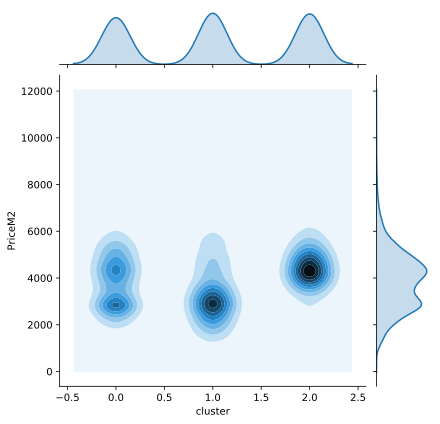

In [17]:
mod_train = scaled_train.copy()
mod_valid = scaled_valid.copy()

# mod_train,mod_valid = normalize_by_price(mod_train, mod_valid, 'Shops_2')

# mod_train.head(10)

# mod_train, mod_valid = drop_column(mod_train, mod_valid, ['Shops_2', 'Ecology_2', 'Ecology_3'])

mod_train, mod_valid, egg = pca_transform(mod_train, mod_valid, 'Ecology_1', ['Ecology_2', 'Ecology_3'])

# mod_train, mod_valid, egg = pca_transform(mod_train, mod_valid, 'DistrictId', ['HouseYear'])

# mod_train, mod_valid = normalize_by_price(mod_train, mod_valid, 'Ecology_1')

CLUSTER_TEST_COUNT = 3

mod_train, mod_valid = set_claster(mod_train, mod_valid, 
                                 ['Social_1', 'Social_3', 'Ecology_1'], CLUSTER_TEST_COUNT)

sns.jointplot(mod_train['cluster'],
              mod_train['PriceM2'], kind='kde');

In [18]:
#Процедура восстанавливает цены в датафрейм для случая оценки по кластерам
#
def add_price_to_frame(df, price, name, cluster):
    
    df = df.copy()
    
    if cluster == 0:
        df[name] = price
        return df
    
    index = 0
    for i in range(cluster):
        
        nexind = index + len(df.loc[df.cluster == i])
        
        df.loc[df.cluster == i, name] = price[index:nexind]
        index = nexind
        
    return df
    

In [19]:
pred_price, egg, spam = random_forest_predict_current(mod_train, mod_valid, WORK_COLUMNS, False, CLUSTER_TEST_COUNT, True)

egg = add_price_to_frame(mod_valid, pred_price, 'PriceNew', CLUSTER_TEST_COUNT)

print("Тест", r2(egg['Price'], egg['PriceNew']) )


АНАЛИЗ / ПРОГНОЗ ЦЕНЫ ЗА МЕТР: False ['DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1', 'Helthcare_2', 'Shops_1', 'Shops_2']
===== сектор 0 =====
{'max_depth': 10, 'min_samples_leaf': 4, 'n_estimators': 100}
      Лучшая оценка регрессии: 0.654807044854748
      Важность признаков:            columns       ffi
2          Square  0.430780
11       Social_3  0.226203
1           Rooms  0.081392
7       HouseYear  0.038703
4   KitchenSquare  0.038103
3      LifeSquare  0.025963
10       Social_2  0.025602
0      DistrictId  0.020182
5           Floor  0.019940
6      HouseFloor  0.018869
9        Social_1  0.017399
8       Ecology_1  0.017279
12   Healthcare_1  0.015957
14        Shops_1  0.013577
13    Helthcare_2  0.010039
16      Shops_2_B  0.000011
15      Shops_2_A  0.000000
      Оценка предсказания, итер 0 0.7081491180441545
===== сектор 1 ===

# Описание стратегии работы с данными


Стратегии:

1. Оставить как есть
2. Удалить
3. Нормализовать по цене
5. Нормализовать по площади (kitchen, life)
6. Нормализовать по площади, нормализовать по цене (kitchen, life)
7. Нормализовать по этажности (Floor)
8. Нормализовать по этажности, нормализовать по цене (Floor)

9. Кластеризовать, нормализовать по цене

10. Снизить размерность с другими колонками (до 4ех колонок) 
	при рейтинге объединения свыше 0.7, объектные колонки превращаем в числовые и удаляем из таблицы
	объединяем только с последующими колонками
11. Снизить размерность, нормализовать по цене
12. Снизить размерность, кластеризовать, нормализовать по цене

Кластеризация на нижнем уровне: от 2 до всех признаков


In [20]:
import random

STRATEGY_ACTIONS = [
    'None',
    'Drop',
    'NormilizeByPrice',
    'NormilizeBySquare',
    'NormilizeBySquarePrice',
    'NormilizeByFloor',
    'NormilizeByFloorPrice',
    'Cluster',
    'PCA',
    'PCAPrice',
    'PCACluster'
]

MAX_STRATEGY_CLASTERS = 10

def random_columns(count, columns, droped_columns=[], i=None):
    
    result = []
    copy = columns.copy()
    droped = droped_columns.copy()
    
    if not i is None:
        copy.remove(i)
    
    while len(droped):
        if droped[0] in copy:
            copy.remove(droped[0])
        del(droped[0])
        
    while count and len(copy):
        val = random.choice(copy)
        copy.remove(val)
        result.append(val)
        if not len(copy):
            break
        count -= 1
        
    return result
    

def get_strategy():
    
    def add_param(action, droped_columns, i):
    
        if action == 'Cluster':
            return random.randint(2, MAX_STRATEGY_CLASTERS)
        elif action == 'PCA' or action == 'PCAPrice' or action == 'PCACluster':
            columns = random_columns(random.randint(1, 4), WORK_COLUMNS, droped_columns, i)
            droped_columns += columns
            return columns
        
    def add_param2(action):
    
        if action == 'PCACluster':
            return random.randint(2, MAX_STRATEGY_CLASTERS)
        
    
    strategy = {}
    droped_columns = []
    for i in WORK_COLUMNS:
        
        action = None
        while action is None:
            action = random.choice(STRATEGY_ACTIONS)
            if action == 'NormilizeBySquare' or action == 'NormilizeBySquarePrice':
                if not i in ['LifeSquare', 'KitchenSquare']:
                    action = None
            if action == 'NormilizeByFloor' or action == 'NormilizeByFloorPrice':
                if not i in ['Floor']:
                    action = None
            
        strategy[i] = {"action":action}
        if action == 'Drop':
            if len(droped_columns) < len(WORK_COLUMNS) - 3:
                droped_columns.append(i)
            else:
                strategy[i]['action'] = 'None'
        
        
    for i in WORK_COLUMNS:
        
        strategy[i]['add_param1'] = add_param(strategy[i]['action'], droped_columns, i)
        if strategy[i]['add_param1'] == []:
            strategy[i]['action'] = "None"
            
        strategy[i]['add_param2'] = add_param2(strategy[i]['action'])
    
    return strategy
    

In [21]:
get_strategy()

{'DistrictId': {'action': 'PCA',
  'add_param1': ['HouseFloor', 'Shops_1'],
  'add_param2': None},
 'Rooms': {'action': 'Drop', 'add_param1': None, 'add_param2': None},
 'Square': {'action': 'Drop', 'add_param1': None, 'add_param2': None},
 'LifeSquare': {'action': 'PCAPrice',
  'add_param1': ['Healthcare_1', 'Ecology_3'],
  'add_param2': None},
 'KitchenSquare': {'action': 'NormilizeBySquarePrice',
  'add_param1': None,
  'add_param2': None},
 'Floor': {'action': 'NormilizeByFloor',
  'add_param1': None,
  'add_param2': None},
 'HouseFloor': {'action': 'None', 'add_param1': None, 'add_param2': None},
 'HouseYear': {'action': 'NormilizeByPrice',
  'add_param1': None,
  'add_param2': None},
 'Ecology_1': {'action': 'PCA',
  'add_param1': ['DistrictId', 'Social_3', 'Helthcare_2', 'Ecology_2'],
  'add_param2': None},
 'Ecology_2': {'action': 'None', 'add_param1': None, 'add_param2': None},
 'Ecology_3': {'action': 'None', 'add_param1': None, 'add_param2': None},
 'Social_1': {'action': 'C

In [22]:
def apply_strategy(strategy, df, vdf):
    
    df = df.copy()
    vdf = vdf.copy()
    
    for col in WORK_COLUMNS:
        
        if not col in df.columns:
            continue
        
        param = strategy[col]
        if param['action'] == 'None':
            continue
            
        elif param['action'] == 'Drop':
            continue
            
        elif param['action'] == 'NormilizeByPrice':
            df, vdf = normalize_by_price(df, vdf, col)
        
        elif param['action'] == 'NormilizeBySquare':
            df, vdf = normalize_by_name(df, vdf, col, 'Square')
        
        elif param['action'] == 'NormilizeBySquarePrice':
            df, vdf = normalize_by_name(df, vdf, col, 'Square')
            df, vdf = normalize_by_price(df, vdf, col)
        
        elif param['action'] == 'NormilizeByFloor':
            df, vdf = normalize_by_name(df, vdf, col, 'HouseFloor')

        elif param['action'] == 'NormilizeByFloorPrice':
            df, vdf = normalize_by_name(df, vdf, col, 'HouseFloor')
            df, vdf = normalize_by_price(df, vdf, col)

        elif param['action'] == 'Cluster':
            df, vdf = claster_normilized_by_price(df, vdf, col, param['add_param1'])

        elif param['action'] == 'PCA':
            egg, spam, ratio = pca_transform(df, vdf, col, param['add_param1'])
            if ratio > 0.6:
                df = egg
                vdf = spam

        elif param['action'] == 'PCAPrice':
            egg, spam, ratio = pca_transform(df, vdf, col, param['add_param1'])
            if ratio > 0.6:
                df, vdf = normalize_by_price(egg, spam, col)
               
        elif param['action'] == 'PCACluster':
            egg, spam, ratio = pca_transform(df, vdf, col, param['add_param1'])
            if ratio > 0.6:
                df, vdf = claster_normilized_by_price(egg, spam, col, param['add_param2'])
            
        else:
            print("Неизвестные параметры", param)
            
    for col in WORK_COLUMNS:
        
        param = strategy[col]
        if param['action'] == 'Drop':
            df, vdf = drop_column(df, vdf, col)
     
    
    return df, vdf

In [23]:
strategy = get_strategy()
print(strategy)
print(scaled_train.columns)
df, vdf = apply_strategy(strategy, scaled_train, scaled_valid)

random_forest_predict_current(df, vdf, WORK_COLUMNS, False, 0, True)

{'DistrictId': {'action': 'NormilizeByPrice', 'add_param1': None, 'add_param2': None}, 'Rooms': {'action': 'PCA', 'add_param1': ['HouseYear', 'Shops_2', 'LifeSquare'], 'add_param2': None}, 'Square': {'action': 'Cluster', 'add_param1': 3, 'add_param2': None}, 'LifeSquare': {'action': 'PCAPrice', 'add_param1': ['Social_1'], 'add_param2': None}, 'KitchenSquare': {'action': 'NormilizeByPrice', 'add_param1': None, 'add_param2': None}, 'Floor': {'action': 'NormilizeByFloor', 'add_param1': None, 'add_param2': None}, 'HouseFloor': {'action': 'PCAPrice', 'add_param1': ['Ecology_3', 'Shops_1', 'Square', 'Social_2'], 'add_param2': None}, 'HouseYear': {'action': 'PCA', 'add_param1': ['Social_3', 'DistrictId'], 'add_param2': None}, 'Ecology_1': {'action': 'Drop', 'add_param1': None, 'add_param2': None}, 'Ecology_2': {'action': 'PCA', 'add_param1': ['HouseFloor', 'Rooms', 'Helthcare_2', 'KitchenSquare'], 'add_param2': None}, 'Ecology_3': {'action': 'PCA', 'add_param1': ['Ecology_2', 'Floor'], 'add_p

(array([257619.00025777, 222048.50866878, 187533.57988512, ...,
        141507.30071537, 131606.09195987, 184585.59745339]),
 0.7176670429821705,
 None)

# Сделаем модель, которая найдет оптимальную модель

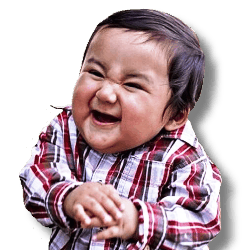

In [ ]:
from datetime import datetime

resultP = [[0, 0, 0, 0, 0]] * 3
resultM2 = [[0, 0, 0, 0, 0]] * 3

COUNT_STRAT = 2888
lochash = []

def exec_strategy(df, vdf, strategy, result, PriceM2):
    
    cluster = 0
    useclus = []
    rand_columns = []
    
    isgoodresult = False
    
    for _ in range(5):
        
        df = df.copy()
        vdf = vdf.copy()
    
        price, egg, spam = random_forest_predict_current(df, vdf, WORK_COLUMNS, PriceM2, cluster, False)

        if result[2][1] < egg:
        
            del(result[0])
            
            result.append([strategy, egg, spam, rand_columns, cluster])
            print("="*8, "by M2:", PriceM2, "="*8)
            print(strategy)
            print("Колонки кластера", rand_columns, "Количество кластеров", cluster)
            print("Лучшее решение:", egg)
            
            isgoodresult = True
        
        #Если попробовали с кластером и все равно не было улучшения - закрываем 
        #попытку по стратегии
        elif cluster != 0 and isgoodresult == False:
            break
        
        cluster = random.randint(2, MAX_STRATEGY_CLASTERS)
        while cluster in useclus:
            cluster = random.randint(2, MAX_STRATEGY_CLASTERS)
        
        rand_columns = [i for i in WORK_COLUMNS if i in df.columns]
        rand_columns = random_columns(random.randint(2, min(len(df.columns) - 1, 8)), rand_columns)

        df, vdf = set_claster(df, vdf, rand_columns, cluster)
        
        useclus.append(cluster)
    
i = 0
mean_time = []

timestamp = datetime.now()

while i <= COUNT_STRAT:
    
    strategy = get_strategy()
    if strategy in lochash:
        continue
        
    lochash.append(strategy)
        
    try:
        df, vdf = apply_strategy(strategy, scaled_train, scaled_valid)
    except Exception as e:
        print("Ошибка Apply strategy:", e)
        continue

    try:
        exec_strategy(df, vdf, strategy, resultP, False)
    except Exception as e:
        print("Ошибка выполнения Price:", e)
        
    try:
        exec_strategy(df, vdf, strategy, resultM2, True)
    except Exception as e:
        print("Ошибка выполнения M2:", e)
        
    timestamp = (datetime.now() - timestamp).seconds
    mean_time.append(timestamp)
    print("Вариант", i, "время обработки", timestamp, "Среднее время обработки", sum(mean_time) / len(mean_time))
    
    timestamp = datetime.now()

    i += 1
    


Вариант 0 время обработки 50 Среднее время обработки 50.0
======== by M2: False ========
{'DistrictId': {'action': 'PCACluster', 'add_param1': ['Ecology_3', 'Social_1'], 'add_param2': 9}, 'Rooms': {'action': 'NormilizeByPrice', 'add_param1': None, 'add_param2': None}, 'Square': {'action': 'PCACluster', 'add_param1': ['Healthcare_1', 'HouseFloor'], 'add_param2': 4}, 'LifeSquare': {'action': 'Cluster', 'add_param1': 6, 'add_param2': None}, 'KitchenSquare': {'action': 'NormilizeByPrice', 'add_param1': None, 'add_param2': None}, 'Floor': {'action': 'NormilizeByFloorPrice', 'add_param1': None, 'add_param2': None}, 'HouseFloor': {'action': 'Cluster', 'add_param1': 4, 'add_param2': None}, 'HouseYear': {'action': 'Drop', 'add_param1': None, 'add_param2': None}, 'Ecology_1': {'action': 'Drop', 'add_param1': None, 'add_param2': None}, 'Ecology_2': {'action': 'PCACluster', 'add_param1': ['Rooms'], 'add_param2': 8}, 'Ecology_3': {'action': 'PCACluster', 'add_param1': ['Social_3', 'LifeSquare', 'He

======== by M2: True ========
{'DistrictId': {'action': 'PCACluster', 'add_param1': ['Ecology_3', 'Social_1'], 'add_param2': 9}, 'Rooms': {'action': 'NormilizeByPrice', 'add_param1': None, 'add_param2': None}, 'Square': {'action': 'PCACluster', 'add_param1': ['Healthcare_1', 'HouseFloor'], 'add_param2': 4}, 'LifeSquare': {'action': 'Cluster', 'add_param1': 6, 'add_param2': None}, 'KitchenSquare': {'action': 'NormilizeByPrice', 'add_param1': None, 'add_param2': None}, 'Floor': {'action': 'NormilizeByFloorPrice', 'add_param1': None, 'add_param2': None}, 'HouseFloor': {'action': 'Cluster', 'add_param1': 4, 'add_param2': None}, 'HouseYear': {'action': 'Drop', 'add_param1': None, 'add_param2': None}, 'Ecology_1': {'action': 'Drop', 'add_param1': None, 'add_param2': None}, 'Ecology_2': {'action': 'PCACluster', 'add_param1': ['Rooms'], 'add_param2': 8}, 'Ecology_3': {'action': 'PCACluster', 'add_param1': ['Social_3', 'LifeSquare', 'Helthcare_2', 'KitchenSquare'], 'add_param2': 7}, 'Social_1':

======== by M2: False ========
{'DistrictId': {'action': 'NormilizeByPrice', 'add_param1': None, 'add_param2': None}, 'Rooms': {'action': 'PCAPrice', 'add_param1': ['Ecology_3', 'Social_3', 'DistrictId', 'HouseFloor'], 'add_param2': None}, 'Square': {'action': 'PCACluster', 'add_param1': ['Healthcare_1', 'Rooms', 'Shops_1'], 'add_param2': 3}, 'LifeSquare': {'action': 'Cluster', 'add_param1': 10, 'add_param2': None}, 'KitchenSquare': {'action': 'PCACluster', 'add_param1': ['LifeSquare', 'HouseYear'], 'add_param2': 4}, 'Floor': {'action': 'NormilizeByPrice', 'add_param1': None, 'add_param2': None}, 'HouseFloor': {'action': 'PCACluster', 'add_param1': ['Floor', 'Ecology_1', 'Helthcare_2'], 'add_param2': 8}, 'HouseYear': {'action': 'PCA', 'add_param1': ['Ecology_2', 'Social_1', 'KitchenSquare'], 'add_param2': None}, 'Ecology_1': {'action': 'PCA', 'add_param1': ['Square', 'Shops_2'], 'add_param2': None}, 'Ecology_2': {'action': 'None', 'add_param1': [], 'add_param2': None}, 'Ecology_3': {'a

Вариант 29 время обработки 45 Среднее время обработки 63.766666666666666
Вариант 30 время обработки 54 Среднее время обработки 63.45161290322581
Вариант 31 время обработки 62 Среднее время обработки 63.40625
Вариант 32 время обработки 55 Среднее время обработки 63.15151515151515
Вариант 33 время обработки 58 Среднее время обработки 63.0
Вариант 34 время обработки 33 Среднее время обработки 62.142857142857146
Вариант 35 время обработки 63 Среднее время обработки 62.166666666666664
Вариант 36 время обработки 59 Среднее время обработки 62.08108108108108
Вариант 37 время обработки 51 Среднее время обработки 61.78947368421053
Вариант 38 время обработки 56 Среднее время обработки 61.64102564102564
Вариант 39 время обработки 57 Среднее время обработки 61.525
Вариант 40 время обработки 60 Среднее время обработки 61.48780487804878
Вариант 41 время обработки 50 Среднее время обработки 61.214285714285715
Вариант 42 время обработки 57 Среднее время обработки 61.116279069767444
Вариант 43 время обр

Вариант 145 время обработки 37 Среднее время обработки 57.602739726027394
Вариант 146 время обработки 56 Среднее время обработки 57.59183673469388
Вариант 147 время обработки 59 Среднее время обработки 57.601351351351354
Вариант 148 время обработки 49 Среднее время обработки 57.54362416107382
Вариант 149 время обработки 74 Среднее время обработки 57.653333333333336
Вариант 150 время обработки 56 Среднее время обработки 57.64238410596027
Вариант 151 время обработки 77 Среднее время обработки 57.76973684210526
Вариант 152 время обработки 56 Среднее время обработки 57.75816993464052
Вариант 153 время обработки 66 Среднее время обработки 57.811688311688314
Вариант 154 время обработки 64 Среднее время обработки 57.851612903225806
Вариант 155 время обработки 65 Среднее время обработки 57.8974358974359
Вариант 156 время обработки 50 Среднее время обработки 57.847133757961785
Вариант 157 время обработки 21 Среднее время обработки 57.61392405063291
Вариант 158 время обработки 75 Среднее время о

======== by M2: False ========
{'DistrictId': {'action': 'NormilizeByPrice', 'add_param1': None, 'add_param2': None}, 'Rooms': {'action': 'Drop', 'add_param1': None, 'add_param2': None}, 'Square': {'action': 'PCAPrice', 'add_param1': ['Social_2', 'Social_3', 'DistrictId'], 'add_param2': None}, 'LifeSquare': {'action': 'Drop', 'add_param1': None, 'add_param2': None}, 'KitchenSquare': {'action': 'NormilizeByPrice', 'add_param1': None, 'add_param2': None}, 'Floor': {'action': 'None', 'add_param1': None, 'add_param2': None}, 'HouseFloor': {'action': 'None', 'add_param1': None, 'add_param2': None}, 'HouseYear': {'action': 'None', 'add_param1': None, 'add_param2': None}, 'Ecology_1': {'action': 'NormilizeByPrice', 'add_param1': None, 'add_param2': None}, 'Ecology_2': {'action': 'PCA', 'add_param1': ['KitchenSquare'], 'add_param2': None}, 'Ecology_3': {'action': 'None', 'add_param1': None, 'add_param2': None}, 'Social_1': {'action': 'PCAPrice', 'add_param1': ['Floor', 'Ecology_1', 'Square', '

Вариант 307 время обработки 72 Среднее время обработки 57.175324675324674
Вариант 308 время обработки 85 Среднее время обработки 57.26537216828479
Вариант 309 время обработки 80 Среднее время обработки 57.33870967741935
Вариант 310 время обработки 73 Среднее время обработки 57.38906752411575
Вариант 311 время обработки 77 Среднее время обработки 57.45192307692308
Вариант 312 время обработки 63 Среднее время обработки 57.46964856230032
Вариант 313 время обработки 66 Среднее время обработки 57.496815286624205
Вариант 314 время обработки 67 Среднее время обработки 57.526984126984125
Вариант 315 время обработки 64 Среднее время обработки 57.54746835443038
Вариант 316 время обработки 60 Среднее время обработки 57.55520504731861
Вариант 317 время обработки 70 Среднее время обработки 57.594339622641506
Вариант 318 время обработки 60 Среднее время обработки 57.60188087774295
Вариант 319 время обработки 77 Среднее время обработки 57.6625
Вариант 320 время обработки 62 Среднее время обработки 57

Вариант 375 время обработки 55 Среднее время обработки 58.409574468085104
Вариант 376 время обработки 69 Среднее время обработки 58.43766578249337
Вариант 377 время обработки 72 Среднее время обработки 58.473544973544975
Вариант 378 время обработки 74 Среднее время обработки 58.514511873350926
Вариант 379 время обработки 38 Среднее время обработки 58.46052631578947
Вариант 380 время обработки 68 Среднее время обработки 58.485564304461946
Вариант 381 время обработки 63 Среднее время обработки 58.49738219895288
Вариант 382 время обработки 54 Среднее время обработки 58.485639686684074
Вариант 383 время обработки 66 Среднее время обработки 58.505208333333336
Вариант 384 время обработки 44 Среднее время обработки 58.467532467532465
Вариант 385 время обработки 42 Среднее время обработки 58.424870466321245
Вариант 386 время обработки 70 Среднее время обработки 58.45478036175711
Вариант 387 время обработки 65 Среднее время обработки 58.47164948453608
Вариант 388 время обработки 61 Среднее врем

Вариант 488 время обработки 38 Среднее время обработки 57.67484662576687
Вариант 489 время обработки 62 Среднее время обработки 57.683673469387756
Вариант 490 время обработки 56 Среднее время обработки 57.680244399185334
Вариант 491 время обработки 50 Среднее время обработки 57.66463414634146
Вариант 492 время обработки 63 Среднее время обработки 57.675456389452336
Вариант 493 время обработки 56 Среднее время обработки 57.67206477732793
Вариант 494 время обработки 48 Среднее время обработки 57.65252525252525
Вариант 495 время обработки 69 Среднее время обработки 57.67540322580645
Вариант 496 время обработки 46 Среднее время обработки 57.65191146881288
Вариант 497 время обработки 56 Среднее время обработки 57.64859437751004
Вариант 498 время обработки 37 Среднее время обработки 57.607214428857716
Вариант 499 время обработки 69 Среднее время обработки 57.63
Вариант 500 время обработки 49 Среднее время обработки 57.612774451097806
Вариант 501 время обработки 53 Среднее время обработки 57.

Вариант 601 время обработки 68 Среднее время обработки 57.90531561461794
Вариант 602 время обработки 65 Среднее время обработки 57.917081260364846
Вариант 603 время обработки 51 Среднее время обработки 57.90562913907285
Вариант 604 время обработки 53 Среднее время обработки 57.897520661157024
Вариант 605 время обработки 60 Среднее время обработки 57.9009900990099
Вариант 606 время обработки 50 Среднее время обработки 57.88797364085667
Вариант 607 время обработки 32 Среднее время обработки 57.8453947368421
Вариант 608 время обработки 60 Среднее время обработки 57.848932676518885
Вариант 609 время обработки 44 Среднее время обработки 57.82622950819672
Вариант 610 время обработки 44 Среднее время обработки 57.803600654664486
Вариант 611 время обработки 60 Среднее время обработки 57.80718954248366
Вариант 612 время обработки 43 Среднее время обработки 57.783034257748774
Вариант 613 время обработки 57 Среднее время обработки 57.78175895765472
Вариант 614 время обработки 64 Среднее время обр

Вариант 714 время обработки 52 Среднее время обработки 57.58041958041958
Вариант 715 время обработки 39 Среднее время обработки 57.55446927374302
Вариант 716 время обработки 104 Среднее время обработки 57.61924686192469
Вариант 717 время обработки 62 Среднее время обработки 57.62534818941504
Вариант 718 время обработки 56 Среднее время обработки 57.623087621696804
Вариант 719 время обработки 46 Среднее время обработки 57.606944444444444
Вариант 720 время обработки 58 Среднее время обработки 57.60748959778086
Вариант 721 время обработки 58 Среднее время обработки 57.60803324099723
Вариант 722 время обработки 53 Среднее время обработки 57.601659751037346
Вариант 723 время обработки 77 Среднее время обработки 57.62845303867403
Вариант 724 время обработки 47 Среднее время обработки 57.61379310344827
Вариант 725 время обработки 51 Среднее время обработки 57.60468319559229
Вариант 726 время обработки 65 Среднее время обработки 57.61485557083906
Вариант 727 время обработки 56 Среднее время об

Вариант 826 время обработки 63 Среднее время обработки 61.37605804111246
Вариант 827 время обработки 66 Среднее время обработки 61.38164251207729
Вариант 828 время обработки 131 Среднее время обработки 61.46562123039807
Вариант 829 время обработки 63 Среднее время обработки 61.46746987951807
Вариант 830 время обработки 51 Среднее время обработки 61.454873646209386
Вариант 831 время обработки 76 Среднее время обработки 61.47235576923077
Вариант 832 время обработки 102 Среднее время обработки 61.52100840336134
Вариант 833 время обработки 132 Среднее время обработки 61.60551558752998
Вариант 834 время обработки 128 Среднее время обработки 61.68502994011976
Вариант 835 время обработки 170 Среднее время обработки 61.81459330143541
Вариант 836 время обработки 136 Среднее время обработки 61.903225806451616
Вариант 837 время обработки 129 Среднее время обработки 61.98329355608592
Вариант 838 время обработки 118 Среднее время обработки 62.05005959475566
Вариант 839 время обработки 120 Среднее в

Вариант 938 время обработки 83 Среднее время обработки 66.85303514376997
Вариант 939 время обработки 99 Среднее время обработки 66.88723404255319
Вариант 940 время обработки 140 Среднее время обработки 66.96493092454836
Вариант 941 время обработки 62 Среднее время обработки 66.95966029723992
Вариант 942 время обработки 119 Среднее время обработки 67.01484623541887
Вариант 943 время обработки 72 Среднее время обработки 67.02012711864407
Вариант 944 время обработки 109 Среднее время обработки 67.06455026455026
Вариант 945 время обработки 103 Среднее время обработки 67.10253699788584
Вариант 946 время обработки 97 Среднее время обработки 67.13410770855333
Вариант 947 время обработки 121 Среднее время обработки 67.19092827004219
Вариант 948 время обработки 132 Среднее время обработки 67.25922023182297
Вариант 949 время обработки 102 Среднее время обработки 67.29578947368421
Вариант 950 время обработки 115 Среднее время обработки 67.34595162986331
Вариант 951 время обработки 140 Среднее вре

Вариант 1050 время обработки 93 Среднее время обработки 71.71931493815414
Вариант 1051 время обработки 146 Среднее время обработки 71.78992395437263
Вариант 1052 время обработки 128 Среднее время обработки 71.84330484330485
Вариант 1053 время обработки 93 Среднее время обработки 71.86337760910816
Вариант 1054 время обработки 71 Среднее время обработки 71.86255924170617
Вариант 1055 время обработки 155 Среднее время обработки 71.94128787878788
Вариант 1056 время обработки 122 Среднее время обработки 71.98864711447493
Вариант 1057 время обработки 101 Среднее время обработки 72.01606805293005
Вариант 1058 время обработки 135 Среднее время обработки 72.07554296506137
Вариант 1059 время обработки 97 Среднее время обработки 72.09905660377359
Вариант 1060 время обработки 122 Среднее время обработки 72.14608859566447
Вариант 1061 время обработки 94 Среднее время обработки 72.16666666666667
Вариант 1062 время обработки 157 Среднее время обработки 72.24647224835371
Вариант 1063 время обработки 1

Вариант 1161 время обработки 52 Среднее время обработки 70.81755593803787
Вариант 1162 время обработки 33 Среднее время обработки 70.78503869303525
Вариант 1163 время обработки 55 Среднее время обработки 70.77147766323024
Вариант 1164 время обработки 56 Среднее время обработки 70.7587982832618
Вариант 1165 время обработки 59 Среднее время обработки 70.74871355060034
Вариант 1166 время обработки 57 Среднее время обработки 70.7369323050557
Вариант 1167 время обработки 44 Среднее время обработки 70.71404109589041
Вариант 1168 время обработки 61 Среднее время обработки 70.70573139435415
Вариант 1169 время обработки 61 Среднее время обработки 70.6974358974359
Вариант 1170 время обработки 47 Среднее время обработки 70.67719897523484
Вариант 1171 время обработки 66 Среднее время обработки 70.67320819112628
Вариант 1172 время обработки 58 Среднее время обработки 70.66240409207161
Вариант 1173 время обработки 42 Среднее время обработки 70.63798977853493
Вариант 1174 время обработки 59 Среднее в

Вариант 1272 время обработки 48 Среднее время обработки 70.42733699921446
Вариант 1273 время обработки 51 Среднее время обработки 70.41208791208791
Вариант 1274 время обработки 30 Среднее время обработки 70.38039215686274
Вариант 1275 время обработки 49 Среднее время обработки 70.36363636363636
Вариант 1276 время обработки 59 Среднее время обработки 70.35473766640564
Вариант 1277 время обработки 56 Среднее время обработки 70.3435054773083
Вариант 1278 время обработки 62 Среднее время обработки 70.33698201720094
Вариант 1279 время обработки 53 Среднее время обработки 70.3234375
Вариант 1280 время обработки 57 Среднее время обработки 70.31303669008587
Вариант 1281 время обработки 66 Среднее время обработки 70.30967238689547
Вариант 1282 время обработки 53 Среднее время обработки 70.29618082618862
Вариант 1283 время обработки 71 Среднее время обработки 70.29672897196262
Вариант 1284 время обработки 60 Среднее время обработки 70.28871595330739
Вариант 1285 время обработки 56 Среднее время 

Вариант 1383 время обработки 46 Среднее время обработки 70.19219653179191
Вариант 1384 время обработки 73 Среднее время обработки 70.1942238267148
Вариант 1385 время обработки 66 Среднее время обработки 70.19119769119769
Вариант 1386 время обработки 51 Среднее время обработки 70.1773612112473
Вариант 1387 время обработки 65 Среднее время обработки 70.17363112391931
Вариант 1388 время обработки 57 Среднее время обработки 70.16414686825054
Вариант 1389 время обработки 45 Среднее время обработки 70.14604316546763
Вариант 1390 время обработки 47 Среднее время обработки 70.1294033069734
Вариант 1391 время обработки 49 Среднее время обработки 70.11422413793103
Вариант 1392 время обработки 39 Среднее время обработки 70.091888011486
Вариант 1393 время обработки 58 Среднее время обработки 70.0832137733142
Вариант 1394 время обработки 69 Среднее время обработки 70.08243727598567
Вариант 1395 время обработки 67 Среднее время обработки 70.08022922636103
Вариант 1396 время обработки 58 Среднее врем

Вариант 1472 время обработки 63 Среднее время обработки 69.36591989137814
Вариант 1473 время обработки 67 Среднее время обработки 69.36431478968792
Вариант 1474 время обработки 67 Среднее время обработки 69.36271186440678
Вариант 1475 время обработки 42 Среднее время обработки 69.34417344173441
Вариант 1476 время обработки 58 Среднее время обработки 69.33649289099526
Вариант 1477 время обработки 36 Среднее время обработки 69.31393775372125
Вариант 1478 время обработки 30 Среднее время обработки 69.28735632183908
Вариант 1479 время обработки 47 Среднее время обработки 69.2722972972973
Вариант 1480 время обработки 47 Среднее время обработки 69.25725860904794
Вариант 1481 время обработки 34 Среднее время обработки 69.23346828609986
Вариант 1482 время обработки 56 Среднее время обработки 69.22454484153742
Вариант 1483 время обработки 52 Среднее время обработки 69.21293800539084
Вариант 1484 время обработки 71 Среднее время обработки 69.21414141414141
Вариант 1485 время обработки 53 Среднее

Вариант 1584 время обработки 48 Среднее время обработки 68.10410094637224
Вариант 1585 время обработки 61 Среднее время обработки 68.09962168978562
Вариант 1586 время обработки 56 Среднее время обработки 68.09199747952111
Вариант 1587 время обработки 49 Среднее время обработки 68.07997481108312
Вариант 1588 время обработки 49 Среднее время обработки 68.06796727501573
Вариант 1589 время обработки 50 Среднее время обработки 68.05660377358491
Вариант 1590 время обработки 67 Среднее время обработки 68.05593966059082
Вариант 1591 время обработки 49 Среднее время обработки 68.04396984924622
Вариант 1592 время обработки 60 Среднее время обработки 68.03892027620842
Вариант 1593 время обработки 56 Среднее время обработки 68.03136762860727
Вариант 1594 время обработки 58 Среднее время обработки 68.02507836990596
Вариант 1595 время обработки 41 Среднее время обработки 68.00814536340852
Вариант 1596 время обработки 53 Среднее время обработки 67.99874765184721
Вариант 1597 время обработки 36 Средне

Вариант 1673 время обработки 31 Среднее время обработки 67.37455197132617
Вариант 1674 время обработки 63 Среднее время обработки 67.37194029850747
Вариант 1675 время обработки 63 Среднее время обработки 67.36933174224343
Вариант 1676 время обработки 56 Среднее время обработки 67.36255217650566
Вариант 1677 время обработки 41 Среднее время обработки 67.34684147794994
Вариант 1678 время обработки 51 Среднее время обработки 67.3371054198928
Вариант 1679 время обработки 56 Среднее время обработки 67.33035714285714
Вариант 1680 время обработки 52 Среднее время обработки 67.32123735871505
Вариант 1681 время обработки 50 Среднее время обработки 67.31093935790726
Вариант 1682 время обработки 36 Среднее время обработки 67.29233511586453
Вариант 1683 время обработки 48 Среднее время обработки 67.28087885985748
Вариант 1684 время обработки 64 Среднее время обработки 67.27893175074183
Вариант 1685 время обработки 58 Среднее время обработки 67.27342823250297
Вариант 1686 время обработки 49 Среднее

Вариант 1785 время обработки 60 Среднее время обработки 66.47144456886898
Вариант 1786 время обработки 42 Среднее время обработки 66.45775041969782
Вариант 1787 время обработки 52 Среднее время обработки 66.4496644295302
Вариант 1788 время обработки 61 Среднее время обработки 66.44661822247065
Вариант 1789 время обработки 57 Среднее время обработки 66.44134078212291
Вариант 1790 время обработки 51 Среднее время обработки 66.43271915131211
Вариант 1791 время обработки 45 Среднее время обработки 66.42075892857143
Вариант 1792 время обработки 31 Среднее время обработки 66.40100390407139
Вариант 1793 время обработки 35 Среднее время обработки 66.3835005574136
Вариант 1794 время обработки 74 Среднее время обработки 66.38774373259054
Вариант 1795 время обработки 67 Среднее время обработки 66.38808463251671
Вариант 1796 время обработки 55 Среднее время обработки 66.38174735670562
Вариант 1797 время обработки 57 Среднее время обработки 66.37652947719688
Вариант 1798 время обработки 63 Среднее 

Вариант 1875 время обработки 41 Среднее время обработки 65.87366737739872
Вариант 1876 время обработки 65 Среднее время обработки 65.87320191795418
Вариант 1877 время обработки 44 Среднее время обработки 65.8615548455804
Вариант 1878 время обработки 58 Среднее время обработки 65.85737094199042
Вариант 1879 время обработки 59 Среднее время обработки 65.85372340425532
Вариант 1880 время обработки 61 Среднее время обработки 65.85114300903774
Вариант 1881 время обработки 49 Среднее время обработки 65.84218916046758
Вариант 1882 время обработки 44 Среднее время обработки 65.83058948486457
Вариант 1883 время обработки 54 Среднее время обработки 65.82430997876858
Вариант 1884 время обработки 53 Среднее время обработки 65.81750663129974
Вариант 1885 время обработки 35 Среднее время обработки 65.80116648992576
Вариант 1886 время обработки 30 Среднее время обработки 65.78219395866455
Вариант 1887 время обработки 47 Среднее время обработки 65.77224576271186
Вариант 1888 время обработки 53 Среднее

Вариант 1986 время обработки 104 Среднее время обработки 66.86361348766985
Вариант 1987 время обработки 75 Среднее время обработки 66.86770623742454
Вариант 1988 время обработки 106 Среднее время обработки 66.88738059326295
Вариант 1989 время обработки 135 Среднее время обработки 66.92160804020101
Вариант 1990 время обработки 142 Среднее время обработки 66.95931692616776
Вариант 1991 время обработки 100 Среднее время обработки 66.97590361445783
Вариант 1992 время обработки 56 Среднее время обработки 66.97039638735575
Вариант 1993 время обработки 159 Среднее время обработки 67.01654964894684
Вариант 1994 время обработки 77 Среднее время обработки 67.02155388471178
Вариант 1995 время обработки 71 Среднее время обработки 67.02354709418837
Вариант 1996 время обработки 117 Среднее время обработки 67.04857285928894
Вариант 1997 время обработки 106 Среднее время обработки 67.06806806806807
Вариант 1998 время обработки 61 Среднее время обработки 67.06503251625813
Вариант 1999 время обработки 1

Вариант 2074 время обработки 62 Среднее время обработки 68.56915662650603
Вариант 2075 время обработки 112 Среднее время обработки 68.59007707129095
Вариант 2076 время обработки 110 Среднее время обработки 68.61001444390949
Вариант 2077 время обработки 63 Среднее время обработки 68.60731472569779
Вариант 2078 время обработки 103 Среднее время обработки 68.62385762385762
Вариант 2079 время обработки 117 Среднее время обработки 68.64711538461539
Вариант 2080 время обработки 49 Среднее время обработки 68.63767419509851
Вариант 2081 время обработки 88 Среднее время обработки 68.64697406340058
Вариант 2082 время обработки 129 Среднее время обработки 68.67594815170428
Вариант 2083 время обработки 71 Среднее время обработки 68.67706333973129
Вариант 2084 время обработки 100 Среднее время обработки 68.69208633093525
Вариант 2085 время обработки 63 Среднее время обработки 68.68935762224353
Вариант 2086 время обработки 112 Среднее время обработки 68.71011020603737
Вариант 2087 время обработки 95

Вариант 2184 время обработки 111 Среднее время обработки 70.39588100686498
Вариант 2185 время обработки 61 Среднее время обработки 70.39158279963404
Вариант 2186 время обработки 110 Среднее время обработки 70.40969364426155
Вариант 2187 время обработки 73 Среднее время обработки 70.41087751371116
Вариант 2188 время обработки 86 Среднее время обработки 70.4179990863408
Вариант 2189 время обработки 101 Среднее время обработки 70.43196347031963
Вариант 2190 время обработки 117 Среднее время обработки 70.45321770880876
Вариант 2191 время обработки 100 Среднее время обработки 70.46669708029196
Вариант 2192 время обработки 121 Среднее время обработки 70.48974008207934
Вариант 2193 время обработки 122 Среднее время обработки 70.51321786690976
Вариант 2194 время обработки 129 Среднее время обработки 70.53986332574031
Вариант 2195 время обработки 98 Среднее время обработки 70.5523679417122
Вариант 2196 время обработки 64 Среднее время обработки 70.54938552571689
Вариант 2197 время обработки 95 

Вариант 2268 время обработки 227 Среднее время обработки 71.58924636403702
Вариант 2269 время обработки 67 Среднее время обработки 71.58722466960353
Вариант 2270 время обработки 88 Среднее время обработки 71.59445178335535
Вариант 2271 время обработки 129 Среднее время обработки 71.61971830985915
Вариант 2272 время обработки 69 Среднее время обработки 71.61856577210735
Вариант 2273 время обработки 81 Среднее время обработки 71.62269129287598
Вариант 2274 время обработки 56 Среднее время обработки 71.61582417582417
Вариант 2275 время обработки 165 Среднее время обработки 71.65685413005272
Вариант 2276 время обработки 74 Среднее время обработки 71.65788317962232
Вариант 2277 время обработки 78 Среднее время обработки 71.66066725197541
Вариант 2278 время обработки 139 Среднее время обработки 71.69021500658184
Вариант 2279 время обработки 91 Среднее время обработки 71.69868421052631
Вариант 2280 время обработки 70 Среднее время обработки 71.6979395002192
Вариант 2281 время обработки 100 Ср

Вариант 2378 время обработки 56 Среднее время обработки 73.15594787725935
Вариант 2379 время обработки 128 Среднее время обработки 73.17899159663865
Вариант 2380 время обработки 117 Среднее время обработки 73.19739605207896
Вариант 2381 время обработки 49 Среднее время обработки 73.1872376154492
Вариант 2382 время обработки 119 Среднее время обработки 73.20646244229962
Вариант 2383 время обработки 102 Среднее время обработки 73.21854026845638
Вариант 2384 время обработки 45 Среднее время обработки 73.20670859538784
Вариант 2385 время обработки 120 Среднее время обработки 73.22632020117351
Вариант 2386 время обработки 109 Среднее время обработки 73.24130708001675
Вариант 2387 время обработки 71 Среднее время обработки 73.24036850921273
Вариант 2388 время обработки 85 Среднее время обработки 73.24529091670155
Вариант 2389 время обработки 101 Среднее время обработки 73.25690376569038
Вариант 2390 время обработки 92 Среднее время обработки 73.26474278544542
Вариант 2391 время обработки 139

Вариант 2487 время обработки 43 Среднее время обработки 73.77934083601286
Вариант 2488 время обработки 61 Среднее время обработки 73.774206508638
Вариант 2489 время обработки 65 Среднее время обработки 73.7706827309237
Вариант 2490 время обработки 57 Среднее время обработки 73.76395022079487
Вариант 2491 время обработки 46 Среднее время обработки 73.75280898876404
Вариант 2492 время обработки 34 Среднее время обработки 73.73686321700762
Вариант 2493 время обработки 34 Среднее время обработки 73.72093023255815
Вариант 2494 время обработки 65 Среднее время обработки 73.71743486973948
Вариант 2495 время обработки 71 Среднее время обработки 73.71634615384616
Вариант 2496 время обработки 44 Среднее время обработки 73.70444533440129
Вариант 2497 время обработки 46 Среднее время обработки 73.693354683747
Вариант 2498 время обработки 60 Среднее время обработки 73.68787515006002
Вариант 2499 время обработки 70 Среднее время обработки 73.6864
Вариант 2500 время обработки 38 Среднее время обработ

Вариант 2599 время обработки 71 Среднее время обработки 73.06038461538462
Вариант 2600 время обработки 63 Среднее время обработки 73.05651672433679
Вариант 2601 время обработки 38 Среднее время обработки 73.04304381245196
Вариант 2602 время обработки 51 Среднее время обработки 73.03457548981945
Вариант 2603 время обработки 41 Среднее время обработки 73.02227342549924
Вариант 2604 время обработки 46 Среднее время обработки 73.01190019193858
Вариант 2605 время обработки 58 Среднее время обработки 73.00613967766692
Вариант 2606 время обработки 67 Среднее время обработки 73.00383582662063
Вариант 2607 время обработки 67 Среднее время обработки 73.00153374233129
Вариант 2608 время обработки 67 Среднее время обработки 72.99923342276735
Вариант 2609 время обработки 52 Среднее время обработки 72.9911877394636
Вариант 2610 время обработки 56 Среднее время обработки 72.98468019915741
Вариант 2611 время обработки 47 Среднее время обработки 72.97473200612558
Вариант 2612 время обработки 47 Среднее

{'DistrictId': {'action': 'NormilizeByPrice', 'add_param1': None, 'add_param2': None}, 'Rooms': {'action': 'None', 'add_param1': None, 'add_param2': None}, 'Square': {'action': 'None', 'add_param1': None, 'add_param2': None}, 'LifeSquare': {'action': 'PCAPrice', 'add_param1': ['KitchenSquare', 'Ecology_3', 'DistrictId', 'Social_3'], 'add_param2': None}, 'KitchenSquare': {'action': 'PCA', 'add_param1': ['HouseYear'], 'add_param2': None}, 'Floor': {'action': 'PCA', 'add_param1': ['Shops_2', 'Rooms', 'LifeSquare'], 'add_param2': None}, 'HouseFloor': {'action': 'None', 'add_param1': None, 'add_param2': None}, 'HouseYear': {'action': 'PCACluster', 'add_param1': ['HouseFloor', 'Shops_1', 'Square'], 'add_param2': 7}, 'Ecology_1': {'action': 'Drop', 'add_param1': None, 'add_param2': None}, 'Ecology_2': {'action': 'Drop', 'add_param1': None, 'add_param2': None}, 'Ecology_3': {'action': 'PCA', 'add_param1': ['Social_2'], 'add_param2': None}, 'Social_1': {'action': 'Drop', 'add_param1': None, 'add_param2': None}, 'Social_2': {'action': 'PCACluster', 'add_param1': ['Floor'], 'add_param2': 7}, 'Social_3': {'action': 'None', 'add_param1': [], 'add_param2': None}, 'Healthcare_1': {'action': 'Drop', 'add_param1': None, 'add_param2': None}, 'Helthcare_2': {'action': 'Drop', 'add_param1': None, 'add_param2': None}, 'Shops_1': {'action': 'None', 'add_param1': [], 'add_param2': None}, 'Shops_2': {'action': 'None', 'add_param1': [], 'add_param2': None}}
Колонки кластера [] Количество кластеров 0
Лучшее решение: 0.7673639881864445

======== by M2: False ========
{'DistrictId': {'action': 'NormilizeByPrice', 'add_param1': None, 'add_param2': None}, 'Rooms': {'action': 'NormilizeByPrice', 'add_param1': None, 'add_param2': None}, 'Square': {'action': 'None', 'add_param1': None, 'add_param2': None}, 'LifeSquare': {'action': 'None', 'add_param1': None, 'add_param2': None}, 'KitchenSquare': {'action': 'PCA', 'add_param1': ['Rooms', 'LifeSquare'], 'add_param2': None}, 'Floor': {'action': 'NormilizeByPrice', 'add_param1': None, 'add_param2': None}, 'HouseFloor': {'action': 'None', 'add_param1': None, 'add_param2': None}, 'HouseYear': {'action': 'PCA', 'add_param1': ['Social_3'], 'add_param2': None}, 'Ecology_1': {'action': 'Cluster', 'add_param1': 6, 'add_param2': None}, 'Ecology_2': {'action': 'None', 'add_param1': None, 'add_param2': None}, 'Ecology_3': {'action': 'PCAPrice', 'add_param1': ['Floor', 'Social_1'], 'add_param2': None}, 'Social_1': {'action': 'PCACluster', 'add_param1': ['KitchenSquare', 'Square', 'Shops_2', 'Helthcare_2'], 'add_param2': 8}, 'Social_2': {'action': 'Cluster', 'add_param1': 9, 'add_param2': None}, 'Social_3': {'action': 'None', 'add_param1': None, 'add_param2': None}, 'Healthcare_1': {'action': 'NormilizeByPrice', 'add_param1': None, 'add_param2': None}, 'Helthcare_2': {'action': 'PCA', 'add_param1': ['Shops_1', 'Healthcare_1', 'HouseFloor'], 'add_param2': None}, 'Shops_1': {'action': 'PCA', 'add_param1': ['Social_2', 'DistrictId'], 'add_param2': None}, 'Shops_2': {'action': 'NormilizeByPrice', 'add_param1': None, 'add_param2': None}}
Колонки кластера ['Square', 'Healthcare_1', 'Shops_1', 'Social_1'] Количество кластеров 2
Лучшее решение: 0.7626455473188098

ЛУЧШИЕ СТРАТЕГИИ
======== by M2: False ========
{'DistrictId': {'action': 'NormilizeByPrice', 'add_param1': None, 'add_param2': None}, 'Rooms': {'action': 'PCACluster', 'add_param1': ['KitchenSquare', 'Shops_1'], 'add_param2': 7}, 'Square': {'action': 'PCA', 'add_param1': ['Shops_2'], 'add_param2': None}, 'LifeSquare': {'action': 'Cluster', 'add_param1': 5, 'add_param2': None}, 'KitchenSquare': {'action': 'NormilizeBySquare', 'add_param1': None, 'add_param2': None}, 'Floor': {'action': 'NormilizeByFloor', 'add_param1': None, 'add_param2': None}, 'HouseFloor': {'action': 'PCA', 'add_param1': ['Ecology_1', 'Square', 'Social_2', 'Social_3'], 'add_param2': None}, 'HouseYear': {'action': 'None', 'add_param1': None, 'add_param2': None}, 'Ecology_1': {'action': 'None', 'add_param1': None, 'add_param2': None}, 'Ecology_2': {'action': 'NormilizeByPrice', 'add_param1': None, 'add_param2': None}, 'Ecology_3': {'action': 'None', 'add_param1': None, 'add_param2': None}, 'Social_1': {'action': 'Drop', 'add_param1': None, 'add_param2': None}, 'Social_2': {'action': 'NormilizeByPrice', 'add_param1': None, 'add_param2': None}, 'Social_3': {'action': 'PCACluster', 'add_param1': ['HouseYear'], 'add_param2': 5}, 'Healthcare_1': {'action': 'Cluster', 'add_param1': 4, 'add_param2': None}, 'Helthcare_2': {'action': 'NormilizeByPrice', 'add_param1': None, 'add_param2': None}, 'Shops_1': {'action': 'NormilizeByPrice', 'add_param1': None, 'add_param2': None}, 'Shops_2': {'action': 'Cluster', 'add_param1': 7, 'add_param2': None}}
Колонки кластера ['Ecology_2', 'Social_3', 'HouseYear', 'Square'] Количество кластеров 8
Лучшее решение: 0.7648858669136599
    
======== by M2: True ========
{'DistrictId': {'action': 'PCACluster', 'add_param1': ['HouseYear', 'Square', 'KitchenSquare'], 'add_param2': 8}, 'Rooms': {'action': 'PCA', 'add_param1': ['Floor', 'Helthcare_2'], 'add_param2': None}, 'Square': {'action': 'None', 'add_param1': None, 'add_param2': None}, 'LifeSquare': {'action': 'Cluster', 'add_param1': 3, 'add_param2': None}, 'KitchenSquare': {'action': 'None', 'add_param1': None, 'add_param2': None}, 'Floor': {'action': 'PCAPrice', 'add_param1': ['DistrictId', 'Shops_1'], 'add_param2': None}, 'HouseFloor': {'action': 'PCAPrice', 'add_param1': ['Social_1', 'Social_2', 'Social_3', 'Ecology_1'], 'add_param2': None}, 'HouseYear': {'action': 'PCACluster', 'add_param1': ['Ecology_3', 'Healthcare_1', 'Shops_2'], 'add_param2': 2}, 'Ecology_1': {'action': 'NormilizeByPrice', 'add_param1': None, 'add_param2': None}, 'Ecology_2': {'action': 'Drop', 'add_param1': None, 'add_param2': None}, 'Ecology_3': {'action': 'PCA', 'add_param1': ['LifeSquare'], 'add_param2': None}, 'Social_1': {'action': 'None', 'add_param1': None, 'add_param2': None}, 'Social_2': {'action': 'None', 'add_param1': None, 'add_param2': None}, 'Social_3': {'action': 'PCA', 'add_param1': ['HouseFloor'], 'add_param2': None}, 'Healthcare_1': {'action': 'PCA', 'add_param1': ['Rooms'], 'add_param2': None}, 'Helthcare_2': {'action': 'Cluster', 'add_param1': 9, 'add_param2': None}, 'Shops_1': {'action': 'None', 'add_param1': None, 'add_param2': None}, 'Shops_2': {'action': 'None', 'add_param1': [], 'add_param2': None}}
Колонки кластера ['Square', 'Social_3', 'DistrictId', 'HouseYear', 'Shops_1', 'Social_2', 'Ecology_3', 'Shops_2'] Количество кластеров 4
Лучшее решение: 0.7716106240249495    

    


In [ ]:
def check_other_rs(df, vdf, result, byPrice, listRS):
    
    best_rez = result[2]
    lstrategy = best_rez[0]
    bestr2 = best_rez[1]
    bestr2m2 = best_rez[2]
    clusters_column = best_rez[3]
    clusters_count = best_rez[4]
    
    df, vdf = apply_strategy(lstrategy, df, vdf)
    
    print("="*8, "by Price", byPrice, "="*8)
    
    print(bestr2, clusters_column, clusters_count)

    if clusters_count > 0:
        df, vdf = set_claster(df, vdf, clusters_column, clusters_count)

    test = []
    
    for i in listRS:
        
        price, egg, spam = random_forest_predict_current(df, vdf, WORK_COLUMNS, byPrice, clusters_count, False, r_state=i)
        egg_table = add_price_to_frame(vdf, price, 'PriceNew', clusters_count)        
        
        test.append([i, egg, spam, 'TEST', r2(egg_table['Price'], egg_table['PriceNew'])])
    
    print(bestr2)
    for i in test:
        print(i)

In [ ]:
#Проверим повторимость результата c другими random_state на тех же данных

listRS = [44]
for i in range(4):
    listRS.append(random.randint(1, 100))
    
check_other_rs(scaled_train, scaled_valid, resultP, False, listRS)

check_other_rs(scaled_train, scaled_valid, resultM2, True, listRS)


In [ ]:
#Проверим что при повторном выполнении всех модификаций получим тот же результат
def get_finaly_data(df, vdf):
    
    df, vdf = ClearData(df, vdf)   

    df = save_columns(df)
    vdf = save_columns(vdf)
    
    scale_columns = [i for i in WORK_COLUMNS if not df[i].dtype == np.dtype('O')]    
    df.loc[:,scale_columns], vdf.loc[:,scale_columns] = scale_data(df, vdf, scale_columns)
    
    return df, vdf
    

In [ ]:
#Проверим воспроизводимость результата при других выборках
for i in range(5):
    
    rs_loc = random.randint(1, 100)
    print(rs_loc)
  
    df, vdf = train_test_split(data, test_size=0.3, random_state = rs_loc)

    df, vdf = get_finaly_data(df, vdf)

    check_other_rs(df, vdf, resultP, False, listRS)

    check_other_rs(df, vdf, resultM2, True, listRS)
    


In [ ]:
best_rez = resultM2[2]

lstrategy =  {'DistrictId': {'action': 'PCACluster', 'add_param1': ['HouseYear', 'Square', 'KitchenSquare'], 'add_param2': 8}, 'Rooms': {'action': 'PCA', 'add_param1': ['Floor', 'Helthcare_2'], 'add_param2': None}, 'Square': {'action': 'None', 'add_param1': None, 'add_param2': None}, 'LifeSquare': {'action': 'Cluster', 'add_param1': 3, 'add_param2': None}, 'KitchenSquare': {'action': 'None', 'add_param1': None, 'add_param2': None}, 'Floor': {'action': 'PCAPrice', 'add_param1': ['DistrictId', 'Shops_1'], 'add_param2': None}, 'HouseFloor': {'action': 'PCAPrice', 'add_param1': ['Social_1', 'Social_2', 'Social_3', 'Ecology_1'], 'add_param2': None}, 'HouseYear': {'action': 'PCACluster', 'add_param1': ['Ecology_3', 'Healthcare_1', 'Shops_2'], 'add_param2': 2}, 'Ecology_1': {'action': 'NormilizeByPrice', 'add_param1': None, 'add_param2': None}, 'Ecology_2': {'action': 'Drop', 'add_param1': None, 'add_param2': None}, 'Ecology_3': {'action': 'PCA', 'add_param1': ['LifeSquare'], 'add_param2': None}, 'Social_1': {'action': 'None', 'add_param1': None, 'add_param2': None}, 'Social_2': {'action': 'None', 'add_param1': None, 'add_param2': None}, 'Social_3': {'action': 'PCA', 'add_param1': ['HouseFloor'], 'add_param2': None}, 'Healthcare_1': {'action': 'PCA', 'add_param1': ['Rooms'], 'add_param2': None}, 'Helthcare_2': {'action': 'Cluster', 'add_param1': 9, 'add_param2': None}, 'Shops_1': {'action': 'None', 'add_param1': None, 'add_param2': None}, 'Shops_2': {'action': 'None', 'add_param1': [], 'add_param2': None}}

bestr2 = best_rez[1]

clusters_column = ['Square', 'Social_3', 'DistrictId', 'HouseYear', 'Shops_1', 'Social_2', 'Ecology_3', 'Shops_2']
clusters_count = 4


In [ ]:
#ФИНАЛЬНЫЙ ТЕСТ

best_rez = resultM2[2]
lstrategy = best_rez[0]
bestr2 = best_rez[1]
bestr2m2 = best_rez[2]
clusters_column = best_rez[3]
clusters_count = best_rez[4]


df, vdf = train_test_split(data, test_size=0.3, random_state = MAIN_DATA_RANDOM_STATE)
  
df, vdf = get_finaly_data(df, vdf)

df, vdf = apply_strategy(lstrategy, df, vdf)
    
if clusters_count > 0:
    df, vdf = set_claster(df, vdf, clusters_column, clusters_count)

price_final = random_forest_predict_current(df, vdf, WORK_COLUMNS, True, clusters_count, False, 
                                                        r_state=MAIN_DATA_RANDOM_STATE, finaly=True)

print(bestr2)

vdf = add_price_to_frame(vdf, price_final, 'PriceNew', clusters_count)        

print('TEST', r2(vdf['Price'], vdf['PriceNew']))


In [ ]:

df, vdf = get_finaly_data(data, test_main_data)

df, vdf = apply_strategy(lstrategy, df, vdf)
    
if clusters_count > 0:
    df, vdf = set_claster(df, vdf, clusters_column, clusters_count)

price_final = random_forest_predict_current(df, vdf, WORK_COLUMNS, True, clusters_count, False, 
                                            r_state=MAIN_DATA_RANDOM_STATE, finaly=True)

vdf = pd.DataFrame(vdf.loc[:,['Id', 'cluster']])

result = add_price_to_frame(vdf, price_final, 'Price',clusters_count)        
result = result[['Id', 'Price']]

result.to_csv('SNaumov_predictions.csv', index=None)

result